In [1]:
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
from shapely import Polygon,Point
from scipy import signal
import json

In [16]:
class InputError(Exception):
    pass

class LoadingError(Exception):
    pass

class OutOfBounds(Exception):
    pass

class FiberCollision(Exception):
    pass

class TipoElectrodo(Enum): 
    punto = 'punto'
    circulo = 'circulo'
    poligono = 'poligono'

class FormaDePloteo(Enum):
    fibras_sin_diametro = 'fibras_sin_diametro'
    fibras_con_diametro = 'fibras_con_diametro'

class PoblacionNervio(Enum):
    uniforme_con_superposicion = 'uniforme_con_superposicion',
    manual = 'manual'
    desde_archivo = 'desde_archivo'
    uniforme_sin_superposicion = "uniforme_sin_superposicion"

class VariacionNodos (Enum):
    uniforme = 'uniforme'
    normal = 'normal'

class TipoEstimulo(Enum):
    sin_nombre = 'sin_nombre'
    cuadrado = 'cuadrado'
    manual = 'manual'
    desde_archivo = 'desde_archivo'
    
def distancia_entre_puntos (x1,y1,x2,y2):
    """Función que mide la distancia entre dos puntos.

    Args:
        x1 (float): Coordenada x del primer punto.
        y1 (float): Coordenada y del primer punto.
        x2 (float): Coordenada x del segundo punto.
        y2 (float): Coordenada y del segundo punto.

    Returns:
        float: La función devuelve la distancia entre los dos puntos.
    """
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

def distancia_entre_circulos(x1,y1,radio1,x2,y2,radio2):
    """Método que devuelve la distancia entre dos círculos.

    Args:
        x1 (float): Coordenada x del primer círculo.
        y1 (float): Coordenada y del primer círculo.
        radio1 (float): Radio del primer círculo.
        x2 (float): Coordenada x del segundo círculo.
        y2 (float): Coordenada y del segundo círculo.
        radio2 (float): Radio del segundo círculo.

    Returns:
        float: Devuelve el cálculo de la distancia entre los dos círculos.
    """
    return (distancia_entre_puntos(x1=x1,y1=y1,x2=x2,y2=y2))-radio1-radio2

def is_inside_circencirc(r1,x1,y1,r0,x0,y0):
    """Función con la que se evalúa si un primer círculo (x1,y1,r1) se encuentra dentro de un segundo círculo (x0,y0,r0).

    Args:
        r1 (float): Radio del primer círculo.
        x1 (float): Coordenada x del primer círculo.
        y1 (float): Coordenada y del primer círculo.
        r0 (float): Radio del círculo al que se le evalúa si contiene al primer círculo.
        x0 (float, optional): Coordenada x del círculo al que se le evalúa si contiene al primer círculo. Por defecto es 0.
        y0 (float, optional): Coordenada y del círculo al que se le evalúa si contiene al primer círculo. Por defecto es 0.

    Returns:
        bool: Devuelve True o False de acuerdo a si el primer círculo está contenido dentro del segundo o no.
    """
    return r0 >= r1 + distancia_entre_puntos(x1=x1,y1=y1,x2=x0,y2=y0)

def funcion_trapecio(x,z,d,a):
    """Función trapecio. Devuelve el valor de la función trapecio para un dado x.

    Args:
        x (float): Valor en el cual se evaluará la función trapecio.
        z (float): Centro simétrico del trapecio.
        d (float): La mitad del valor del largo inferior del trapecio.
        a (float): La mitad del largo superior del trapecio.

    Returns:
        float: Devuelve el valor de la función evaluado en un dado x.
    """
    if (x>z-d-a and x<z-a):
        return (x-z+d+a)/d
    elif (x>z+a and x<z+a+d):
        return (z+a+d-x)/d
    elif (x>=z-a and x<=z+a):
        return 1
    else:
        return 0

def funcion_gaussiana(x,z,d,a):
    """Función exponencial con caída como una función gaussiana. 

    Args:
        x (float): Valor en el cual se evaluará la función.
        z (float): mu, esperanza de la función gaussiana.
        d (float): Valor hasta el cual se quiere lograr la caída de la función.
        a (float): Valor hasta el cual se quiere mantener la función igual a 1.

    Returns:
        float: Devuelve el valor de la función evaluado en un dado x.
    """
    if (x>z-d-a and x<z-a):
        exponente = -(x - (z -a))**2 / (2 * (d/3)**2)
        return np.exp(exponente)
    elif (x>z+a and x<z+a+d):
        exponente = -(x - (z +a))**2 / (2 * (d/3)**2)
        return np.exp(exponente)
    elif (x>=z-a and x<=z+a):
        return 1
    else:
        return 0

def funcion_constante(x,z,d,a,valor):
    """Función que devuelve un valor constante en un cierto rango.

    Args:
        x (float): Valor en el cual se evaluará la función.
        z (float): Centro de la función.
        d (float): Valor del ancho de la función.
        a (float): Extensión para el ancho de la función.
        valor (float): El valor de la función cuando no es cero.

    Returns:
        _type_: Devuelve el valor de la función evaluado en un dado x.
    """
    if x>=z-d-a and x<=z+d+a:
        return valor
    else:
        return 0

def insertar_estimulo(estimulo,posicion,fm,tiempo_registro,velocidad,peso):
    """Función que desplaza un numpy array dada una posición de inicio.

    Args:
        estimulo (numpy.ndarray): Señal que es desplazada.
        posicion (float): Posición hasta la que se desplazará el estímulo.
        fm (float): Frecuencia de muestreo de la señal.
        tiempo_registro (float): Tiempo total en el que se hará el registro.
        velocidad (float): Velocidad a la cual se desplaza la señal.
        peso (float): Factor por el cual se multiplica la señal.

    Returns:
        numpy.ndarray: Devuelve el estímulo desplazado, en el tiempo de registro.
    """
    total_muestras = int(tiempo_registro * fm)
    #tiempo = np.arange(1/fm,tiempo_registro+1/fm,1/fm)
    muestras_estimulo = len(estimulo)
    vector = np.zeros(total_muestras)

    inicio = int((posicion/(velocidad*1000000)) * fm) #retardo
    
    if muestras_estimulo > (total_muestras - inicio):
        muestras_estimulo = total_muestras-inicio
    
    if peso == 0:
        pass
    else:
        vector[inicio:inicio+muestras_estimulo] = estimulo[:muestras_estimulo]*peso
  
    return vector

def array_to_multiarray(array,estimulo,fm,tiempo_registro,velocidad,peso):
    """Función que, dado un array con posiciones, crea un array de arrays, con estímulos desplazados dada cada posición.

    Args:
        array (numpy.ndarray): Array que contiene las posiciones de desplazamiento del estímulo.
        estimulo (numpy.ndarray): Señal que es desplazada.
        fm (float): Frecuencia de muestreo de la señal.
        tiempo_registro (float): Tiempo total en el que se hará el registro.
        velocidad (float): Velocidad a la cual se desplaza la señal.
        peso (float): Factor por el cual se multiplica la señal.

    Returns:
        numpy.ndarray: Devuelve el array de arrays con los estímulos desplazados.
    """
    for i,posicion in enumerate(array):
        if i == 0:
            multiarray = [insertar_estimulo(estimulo=estimulo,posicion=posicion,fm=fm,tiempo_registro=tiempo_registro,velocidad=velocidad,peso=peso[i])]
        else:
            a = insertar_estimulo(estimulo=estimulo,posicion=posicion,fm=fm,tiempo_registro=tiempo_registro,velocidad=velocidad,peso=peso[i])
            multiarray = np.vstack((multiarray,a))
    return multiarray

class Nervio:
    """Nervio.
    """
    def __init__(self,diametro = 250,longitud = 50000,conductividad_transversal = None,porcentaje_cobertura = None):
        """Método constructor de la clase Nervio.

        Args:
            diametro (int, optional): Diámetro del nervio. Por defecto 250 um.
            longitud (int, optional): _description_. Por defecto 50000.
            conductividad_transversal (float, optional): Conductividad transversal del nervio. Por defecto None.
            porcentaje_cobertura (float, optional): Porcentaje del nervio al cual llega el electrodo. Por defecto None.

        Raises:
            InputError: Se levanta este error si no se ingresa un valor de conductividad_transversal o de pocentaje_cobertura, dado que uno de los dos es necesario para realizar cálculos posteriores.
        """
        self.radio = diametro/2
        self.fibras = []
        self.cantidad_fibras = 0
        self.limite_lateral_izquierdo = -self.radio
        self.limite_lateral_derecho = self.radio
        self.limite_superior = self.radio
        self.limite_inferior = -self.radio
        self.centro_nervio_x = 0
        self.centro_nervio_y = 0 
        self.informacion_nodos = []
        self.longitud_nervio = longitud
        self.conductividad_transversal = conductividad_transversal
        self.porcentaje_cobertura = porcentaje_cobertura
        self.metodo_poblacion = None
        self.distancia_nodos_promedio = None

        if self.conductividad_transversal is None and self.porcentaje_cobertura is None:
            raise InputError("Se debe ingresar ya sea un valor de conductividad transversal o un porcentaje de cobertura.")
    
    def info_nervio(self):
        """Método que devuelve un diccionario con información del nervio.

        Returns:
            dict: Diccionario con información del nervio.
        """
        return {
            "diametro" : 2 * self.radio,
            "cantidad_fibras" : self.cantidad_fibras,
            "longitud" : self.longitud_nervio,
            "posicion_centro_nervio" : [self.centro_nervio_x,self.centro_nervio_y],
            "conductividad_transversal" : self.conductividad_transversal,
            "porcentaje_de_cobertura" : self.porcentaje_cobertura
        }
        
    def informacion_fibras(self):
        """Método para obtener una lista con la información de las fibras dentro del nervio.

        Returns:
            numpy.ndarray: Devuelve un array cuyas dos primeras columnas son las coordenadas x e y de cada fibra, y la tercera columna contiene información del diámetro de las fibras.
        """
        return np.array([fibra.obtener_info_fibra() for fibra in self.fibras])
 
    def poblar(self,metodo_poblacion='uniforme_con_superposicion',num_fibras=200,semilla=None,diametro_fibra = 0, var_diametro = 0,alfa = 7.6,velocidad = None,**kwargs):
        """Método para poblar el nervio con las fibras nerviosas.

        Args:
            metodo_poblacion (str, optional): Tipo de método de población de fibras en el nervio. Por defecto es 'uniforme'.
            num_fibras (int, optional): Número de fibras que contendrá el nervio. Por defecto son 200.
            semilla (int, optional): Número de la semilla. Por defecto es None.
            diametro_fibra (float, optional): Diámetro de la fibra en micrones. Por defecto es 0, si se trata de fibras puntuales.
            var_diametro (int, optional): La variación del diámetro se hace con la función normal, por lo que este es el sigma. Por defecto es 0 (sin variación). En micrómetro.
            alfa (float, optional): Valor para calcular la velocidad de conducción de las fibras. Por defecto es 7.6. En [m/s/micrómetro]
            velocidad (float,optional): Velocidad de la fibra en [m/s].
        
        Keyword Args:
            lista_fibras (numpy.ndarray): Array con la ubicación y diámetro de las fibras en el método de población manual.
            ubicacion_archivo (str): String con la ubicación del archivo csv para el método de población desde_archivo.

        Raises:
            InputError: Si el método de población ingresado no se encuentra entre las opciones disponibles.
        """
        self.metodo_poblacion = metodo_poblacion
        if metodo_poblacion == PoblacionNervio.uniforme_con_superposicion.name:
            self.uniforme_con_superposicion(num_fibras=num_fibras,semilla=semilla,diametro_fibra=diametro_fibra,var_diametro = var_diametro,alfa = alfa,velocidad=velocidad)
        elif metodo_poblacion == PoblacionNervio.uniforme_sin_superposicion.name:
            self.uniforme_sin_suporsicion(num_fibras=num_fibras,semilla=semilla,diametro_fibra=diametro_fibra,var_diametro=var_diametro,alfa = alfa,velocidad=velocidad)
        elif metodo_poblacion == PoblacionNervio.manual.name:
            self.manual(lista_fibras = kwargs.get('lista_fibras',None))
        elif metodo_poblacion == PoblacionNervio.desde_archivo.name:
            self.desde_archivo(ubicacion_archivo = kwargs.get('ubicacion_archivo',None))
        else:
            raise InputError ('El método de población ingresado no es correcto.')
        
    def uniforme_con_superposicion(self,num_fibras,semilla,diametro_fibra,var_diametro,alfa,velocidad):
        """Función para poblar el nervio con distribución uniforme, con superposición de las fibras.

        Args:
            num_fibras (int, optional): Número de fibras que contendrá el nervio.
            semilla (int, optional): Número de la semilla.
            diametro_fibra (float, optional): Diámetro de la fibra en micrones.
            var_diametro (int, optional): La variación del diámetro se hace con la función normal, por lo que este es el sigma.
            alfa (float, optional): Valor para calcular la velocidad de conducción de las fibras.
        """
        #Tiene centro en (0,0), implementar el traslado 
        np.random.seed(semilla)
        longitud = np.random.uniform(0,self.radio**2, size = num_fibras)
        angulo = np.pi * np.random.uniform(0,2,size = num_fibras)
        diam = []
        while len(diam) < num_fibras:
            diametro = np.random.normal(diametro_fibra,var_diametro)
            if diametro > 0:
                diam.append(diametro)    
        # diametros = np.random.normal(diametro_fibra,var_diametro,size = num_fibras) 
        # diametros = np.abs(diametros)
        x = np.sqrt(longitud) * np.cos(angulo)
        y = np.sqrt(longitud) * np.sin(angulo)
        matriz = np.column_stack((x,y,np.array(diam)))
        #matriz = np.column_stack((x,y,diam))
        self.fibras = [Fibra(x=x,y=y,diametro=diam,velocidad = alfa*diam) if velocidad is None else Fibra(x=x,y=y,diametro=diam,velocidad = velocidad) for x,y,diam in matriz] 
        self.cantidad_fibras = num_fibras

    def uniforme_sin_suporsicion(self,num_fibras,semilla,diametro_fibra,var_diametro,alfa,velocidad):
        """Función para poblar el nervio con distribución uniforme, sin superposición de las fibras.

        Args:
            num_fibras (int, optional): Número de fibras que contendrá el nervio.
            semilla (int, optional): Número de la semilla.
            diametro_fibra (float, optional): Diámetro de la fibra en micrones.
            var_diametro (int, optional): La variación del diámetro se hace con la función normal, por lo que este es el sigma.
            alfa (float, optional): Valor para calcular la velocidad de conducción de las fibras.
        """
        np.random.seed(semilla)
        lista = []
        
        
        while len(lista) < num_fibras:
            choque = False
            length = np.random.uniform(0,self.radio**2)
            angle = np.pi * np.random.uniform(0, 2)
            diam = np.random.normal(diametro_fibra,var_diametro)
            while diam<=0:
                diam = np.random.normal(diametro_fibra,var_diametro)
            # diam = np.abs(np.random.normal(diametro_fibra,var_diametro))
            # diam = np.abs(diam)
            x = np.sqrt(length) * np.cos(angle)
            y = np.sqrt(length) * np.sin(angle)

            for a,b,c in lista:
                if distancia_entre_circulos(x,y,diam/2,a,b,c/2) < 0:
                    choque = True
            if choque is False and is_inside_circencirc(diam/2,x,y,self.radio,self.centro_nervio_x,self.centro_nervio_y):
                lista.append([x,y,diam])
        #! ver si hago como los diametros en los 2 metodos de arriba
        #self.fibras = [Fibra(x,y,diam,velocidad) if velocidad is not None else Fibra(x,y,diam,alfa*diam) for x,y,diam in lista]
        self.fibras = [Fibra(x=x,y=y,diametro=diam,velocidad=alfa*diam) if velocidad is None else Fibra(x=x,y=y,diametro=diam,velocidad=velocidad) for x,y,diam in lista]
        self.cantidad_fibras = num_fibras
        
    def manual(self,lista_fibras): #! ver si hago que si o si entre NUEVO, VER SI LE CAMBIO EL NOMBRE A LISTA_FIBRAS POR INFO_FIBRAS
        """Función para poblar el nervio de forma manual, a partir de un array con la posición de las fibras, y sus diámetros.

        Args:
            lista_fibras (numpy.ndarray): Array con la posición y diámetros de las fibras, si lo tuviera.
            diametro_fibra (float): Diámetro que se le dará a la fibra, si es que lista_fibras no tuviera una columna con esta información.
            alfa (float, optional): Valor necesario para calcular la velocidad de conducción de las fibras.

        Raises:
            OutOfBounds: Error que se levanta si se encuentra que alguna de las fibras ingresadas supera los límites del nervio.
        """
        try:  
            f = [Fibra(x,y,d,v) for x,y,d,v in lista_fibras if is_inside_circencirc(d/2,x,y,self.radio,self.centro_nervio_x,self.centro_nervio_y)]
        except ValueError:
            raise ValueError ('Se necesitan los datos de ubicación de fibras en eje x e y, diámetros y velocidades para este método.')
        
        if len(f)!=len(lista_fibras):
            raise OutOfBounds ("Se encontró por lo menos una fibra fuera de los límites del nervio.")
                
        self.fibras= f
        self.cantidad_fibras = len(lista_fibras)
    
    def desde_archivo(self,ubicacion_archivo): #! nuevo
        """Función para poblar un nervio, a partir de un archivo csv.

        Args:
            diametro_fibra (float): Diámetro que se le dará a la fibra, si es que lista_fibras no tuviera una columna con esta información.
            ubicacion_archivo (str): String con la ubicación del archivo csv.
            alfa (float, optional): Valor necesario para calcular la velocidad de conducción de las fibras.

        Raises:
            LoadingError: Error que se levanta cuando no se puede cargar el archivo.
            ValueError: Error que se levanta cuando se detecta que algún caracter ingresado en el archivo no es numérico.
        """
        try:
            fibras = np.genfromtxt(ubicacion_archivo, delimiter = ',')
        except Exception as e:
            raise LoadingError('Fallo en carga de archivo.') from e
        
        if not np.isnan(sum(fibras)).any() and np.issubdtype(fibras.dtype, np.number):
            self.manual_final(lista_fibras = fibras)   
        else:
            raise ValueError ("La lista contiene caracteres que no son números.")

    def ploteo_fibras_puntos(self,borde_nervio = 'blue', relleno_nervio = 'None', color_fibras = 'r'):
        """Método para graficar una vista transversal del nervio. Las fibras se muestran como puntos (sin diámetro real).

        Args:
            borde_nervio (str, optional): Color del borde del nervio. Por defecto es azul ('blue').
            relleno_nervio (str, optional): Color del relleno del nervio. Por defecto no tiene color ('None').
            color_fibras (str, optional): Color de las fibras, graficadas como puntos. Escribirlo según formato aceptable por Matplotlib. Por defecto es rojo ('r').
        """
        
        #Ploteo de las fibras
        forma_fibras = color_fibras + " ."
        matriz = self.informacion_fibras()
        plt.plot(matriz[:,0],matriz[:,1],forma_fibras,label = 'Fibras')

        #Ploteo del nervio
        plt.gca().add_patch(plt.Circle((0,0),self.radio, edgecolor = borde_nervio, facecolor = relleno_nervio,label = 'Nervio'))
        
        # plt.axis('equal')
        # plt.show()
    
    def ploteo_fibras_circulos(self, borde_nervio = 'blue', relleno_nervio = 'None', borde_fibras = 'red', relleno_fibras = 'None'):
        """Método para graficar una vista transversal del nervio. Las fibras se muestran como círculos, con su respectivo diámetro.

        Args:
            borde_nervio (str, optional): Color del borde del nervio. Por defecto es azul ('blue').
            relleno_nervio (str, optional): Color del relleno del nervio. Por defecto no tiene color ('None').
            borde_fibras (str, optional): Color del borde de las fibras. Por defecto es rojo ('red').
            relleno_fibras (str, optional): Color del relleno de las fibras. Por defecto no tiene color ('None').

        Raises:
            InputError: Cuando se encuentra por lo menos una fibra con diámetro igual a 0.
        """
        matriz = self.informacion_fibras()
        if matriz[:,2].any() == 0:
            raise InputError ("Por lo menos una fibra tiene diámetro igual a 0.")

        #Ploteo de las fibras
        for i in range(len(matriz)):
            circle = plt.Circle((matriz[i,0],matriz[i,1]),matriz[i,2],edgecolor = borde_fibras,facecolor = relleno_fibras,label="Fibras" if i == 0 else "")
            plt.gca().add_patch(circle)

        #Ploteo del nervio
        plt.gca().add_patch(plt.Circle((0,0),self.radio, edgecolor = borde_nervio, facecolor = relleno_nervio, label = 'Nervio'))

        # plt.axis('equal')
        # plt.show()
   
    def agregar_nodos(self,distancia_nodos,variacion,desplazamiento,distribucion_variacion = 'uniforme'):
        """Método que permite agregar nodos a las fibras. 

        Args:
            distancia_nodos (flaot): Distancia entre nodos en las fibras en micrómetros.
            variacion (float): Variación de la distancia entre nodos en micrómetros.
            desplazamiento (float): Desplazamiento de los nodos en micrómetros. 
            distribucion_variacion (str, optional): Distribución de la variación de la distancia entre nodos. Se espera un valor correspondiente a alguna de las opciones de VariacionNodos. Por defecto es 'uniforme'.
        """
        self.distancia_nodos_promedio = distancia_nodos
        self.informacion_nodos = [f.ubicar_nodos(distancia_nodos = distancia_nodos,variacion = variacion, desplazamiento=np.random.uniform(-desplazamiento,desplazamiento),distribucion_variacion=distribucion_variacion,longitud_fibra= self.longitud_nervio) for f in self.fibras]

class Fibra: 
    """Fibra.
    """
    def __init__(self,x,y,diametro,velocidad):
        """Método constructor de la clase Fibra.

        Args:
            x (float): Posición x del centro de la fibra. En micrómetros.
            y (float): Posición y del centro de la fibra. En micrómetros.
            diametro (float): Diámetro de la fibra. En micrómetros.
            alfa (float): Valor necesario para calcular la velocidad de conducción de la fibra. En [m/(s*micrómetros)]
        """
        
        self.x = x
        self.y = y
        self.radio = diametro/2 
        self.ubicacion_nodos = []
        self.velocidad = velocidad

    def info_fibra(self,numero,pesos,estimulo):
        datos_fibras = {
                        "fibra": numero,
                        "posicion_transversal_fibra" : [self.x,self.y],
                        "diametro" : 2*self.radio,
                        "velocidad" : self.velocidad,
                        "nodos": [{"ubicacion": ubicacion,"peso": pesos[i],"estimulo": estimulo[i].tolist()} for i,ubicacion in enumerate(self.ubicacion_nodos)]
                        }
        return datos_fibras   
        
    def obtener_info_fibra(self):
        """Método que permite obtener información sobre la fibra, en forma de lista.

        Returns:
            list: Información sobre la fibra (posición en eje x, posición en eje y, radio de la fibra).
        """
        return [self.x,self.y,self.radio,self.velocidad]
    
    def ubicar_nodos(self,longitud_fibra,distancia_nodos,variacion,desplazamiento, distribucion_variacion):
        """Método para agregar nodos a una fibra.
        Args:
            longitud_fibra (float): Longitud de la fibra en micrómetros.
            distancia_nodos (flaot): Distancia entre nodos en las fibras en micrómetros.
            variacion (float): Variación de la distancia entre nodos en micrómetros.
            desplazamiento (float): Desplazamiento de los nodos en micrómetros. 
            distribucion_variacion (str, optional): Distribución de la variación de la distancia entre nodos. Se espera un valor correspondiente a alguna de las opciones de VariacionNodos. Por defecto es 'uniforme'.

        Returns:
            list: Devuelve la ubicación de los nodos de la fibra.
        """
        arr = np.arange(-longitud_fibra/2,longitud_fibra*1.5 +1,distancia_nodos)
        if distribucion_variacion == VariacionNodos.uniforme.name:
            var = np.random.uniform(-variacion/2,variacion/2,len(arr)) + desplazamiento
        elif distribucion_variacion == VariacionNodos.normal.name:
            var = np.random.normal(0,variacion,len(arr)) + desplazamiento
        
        ubicacion = arr + var
        ubicacion = ubicacion[(ubicacion > 0) & (ubicacion < longitud_fibra)]
        self.ubicacion_nodos = ubicacion
        return ubicacion

class Electrodo:    
    """Electrodo.
    """
    def __init__(self,tipo,zona_influencia,grosor = 0,**kwargs):
        """Método constructor de la clase Electrodo.

        Args:
            tipo (str): Tipo de electrodo. Puede ser los enumerados en el Enum TipoElectrodo.
            zona_influencia (float): Es la zona a cualquiera de los lados a la cual tiene alcance el electrodo.
            grosor (int, optional): Grosor del electrodo. Por defecto es 0.
        
        Keyword Args:
            pos_x (float): Posición del electrodo en el eje x. En micrómetros.
            pos_y (float): Posición del electrodo en el eje y. En micrómetros.
            pos_z (float): Posición del electrodo en el eje z. En micrómetros.
            radio (float): Radio del electrodo tipo Circulo. En micrómetros.
            lista_coordenadas (list): Coordenadas del electrodo tipo Poligono.

        Raises:
            InputError: Si el tipo de electrodo ingresado no es correcto.
            Exception: Si no se ingresan los parámetros necesarios para cada tipo de electrodo.
        """

        try:
            self.tipo = tipo
        except ValueError as e:
            raise InputError('El tipo de electrodo ingresado no es correcto.') from e
        
        self.dist_al_electrodo = []
        self.wmax = [] 
        self.wlong = []
        self.pesos = []
        self.grosor = grosor
        self.zona_influencia = zona_influencia #es la zona a izquierda o derecha que abarca el electrodo, no la zona completa
        self.sfap = None
        self.cap = None
        self.array_estimulos = None
        
        if self.tipo == TipoElectrodo.punto.name:
            self.x = kwargs.get('pos_x')
            self.y = kwargs.get('pos_y')
            self.z = kwargs.get('pos_z')
            self.shape = Point(self.x,self.y)
            if self.x is None or self.y is None or self.z is None:
                raise Exception('Los parámetros pos_x, pos_y, pos_z son necesarios para electrodo tipo Punto.')
        elif self.tipo == TipoElectrodo.circulo.name:
            self.x = kwargs.get('pos_x')
            self.y = kwargs.get('pos_y')
            self.z = kwargs.get('pos_z')
            self.radio = kwargs.get('radio')
            self.shape = Point(self.x,self.y).buffer(self.radio)
            if self.x is None or self.y is None or self.radio is None or self.z is None:
                raise Exception('Los parámetros pos_x, pos_y, pos_z, radio son necesarios para el electrodo tipo Círculo.')
        elif self.tipo == TipoElectrodo.poligono.name:
            self.z = kwargs.get('pos_z')
            self.coordenadas = kwargs.get('lista_coordenadas')
            self.shape = Polygon(self.coordenadas)
            if self.z is None or self.coordenadas is None:
                raise Exception("Los parámetros pos_z y lista_coordenadas son necesarios para el electrodo tipo Polígono.")

    def info_electrodo(self,idx):
        return {
            "electrodo_numero" : idx,
            "tipo": self.tipo,
            "posicion_transversal_electrodo": [self.x,self.y],
            "posicion_longitudinal_electrodo": self.z,
            "espesor": self.grosor,
            "zona_de_influencia": self.zona_influencia,
        }
        
    def ploteo_electrodo(self,idx):
        """_summary_

        Args:
            idx (int): Ubicación del electrodo en la lista de electrodos de la clase Entorno.
        """
        if self.tipo == TipoElectrodo.punto:
            x,y = self.shape.x,self.shape.y
            plt.plot(x,y,'.',label = f"Electrodo {idx}")
        elif self.tipo == TipoElectrodo.circulo or self.tipo == TipoElectrodo.poligono:
            x,y = self.shape.exterior.xy
            plt.plot(x,y,label = f"Electrodo {idx}")

    def calcular_distancias(self,lista_fibras): 
        """Método para calcular distancias desde el electrodo a las fibras.

        Args:
            lista_fibras (list): Liista de objetos Fibra.
        """
        self.dist_al_electrodo = np.array([self.shape.distance(Point(f.x,f.y)) if f.radio == 0 else self.shape.distance(Point(f.x,f.y).buffer(f.radio)) for f in lista_fibras]) 

    def calcular_wmax(self,nervio):
        """Método para calcular los Wmax para cada fibra del nervio.

        Args:
            nervio (Nervio): El nervio que contiene las fibras con las cuales se calculará el Wmax.
        """
               
        if nervio.conductividad_transversal != None:
            cond_transversal = nervio.conductividad_transversal
        else:
            cond_transversal = nervio.porcentaje_cobertura/100 * max(self.dist_al_electrodo)

        self.wmax = np.array([1-(x/cond_transversal) if (x>=0 and x<cond_transversal) else 0 for x in self.dist_al_electrodo])
    
    def calcular_wlong(self,funcion,matriz_nodos): 
        """Método para calcular los Wlong por cada nodo de cada fibra.

        Args:
            funcion (Callable): Función con la cual se calcularán los Wlong
            matriz_nodos (list): Lista con la información de la ubicación de nodos de cada fibra.
        """
        a = self.grosor/2
        d = self.zona_influencia
        wlong = np.array([np.array([funcion(x=x, z=self.z, a=a, d=d) for x in lista]) for lista in matriz_nodos])
        self.wlong = wlong
    
    def calcular_pesos(self,nervio,funcion,matriz_nodos):
        """Método que calcula los pesos en cada nodo para cada fibra del nervio.

        Args:
            nervio (Nervio): Objeto de la clase Nervio. Nervio que contiene las fibras.
            funcion (Callable): Función con la cual se calcularán los Wlong.
            matriz_nodos (list): Lista con la ubicación de los nodos de cada fibra.
        """
        self.calcular_wmax(nervio)
        self.calcular_wlong(funcion,matriz_nodos)
        self.pesos = np.array([np.array([wmax * wlong for wlong in lista_wlong]) for wmax, lista_wlong in zip(self.wmax, self.wlong)])
    
    def sfap_funcion(self,frec_muestreo,velocidad_fibras,tiempo_registro,estimulo,ubicacion_nodos,num_fibras):
        estimulo_por_nodo = [array_to_multiarray(array = fibra,estimulo=estimulo[i],fm=frec_muestreo,tiempo_registro = tiempo_registro,velocidad=velocidad_fibras[i],peso = self.pesos[i]) for i,fibra in enumerate(ubicacion_nodos)]
        for i in range(len(estimulo_por_nodo)): #desde 0 al num de fibras
            sfap = np.sum(estimulo_por_nodo[i],axis = 0)
            if i == 0:
                sfap_matriz = [sfap]
            else:
                sfap_matriz = np.vstack((sfap_matriz,sfap))

        self.array_estimulos = estimulo_por_nodo
        self.sfap = sfap_matriz/num_fibras
        
    def cap_funcion(self):
        self.cap = np.sum(self.sfap,axis = 0)
    
class Estimulador:
    """Encargado de generar el impulso de entrada al Nervio.
    """
    def __init__(self,frec_muestreo, tiempo_estimulo, num_fibras):
        """Método constructor de la clase Estimulador.

        Args:
            frec_muestreo (float): Frecuencia de muestreo.
            tiempo_estimulo (float): Tiempo total que durará el registro.
            num_fibras (int): Número de fibras del nervio.
        """
        self.cant_muestras = int(frec_muestreo*tiempo_estimulo) #!para que sea entero
        self.frec = frec_muestreo
        self.tiempo_estimulo = tiempo_estimulo
        self.num_fibras = num_fibras
        self.estimulo = None
        self.vector_tiempo = np.arange(1/self.frec,self.tiempo_estimulo+1/self.frec,1/self.frec)
        self.tipo_estimulo = None
    
    def crear_estimulo(self,tipo_estimulo,**kwargs):
        """Método para crear el estímulo que se usará con las fibras del nervio.

        Args:
            tipo_estimulo (str): Tipo de estímulo que se creará. Se detallan en el enum TipoEstimulo. En segundos.
            tiempo_inicio (float, optional): Momento en el que inicia el estímulo. Por defecto es 0. En segundos.
        
        Keyword Args:
            duracion(float): Tiempo en segundos que durará la señal cuadrada.
            lista_tiempo_inicio(list): Lista con los tiempos en los cuales se quiere tener una spike.
            frec_corte(float): Frecuencia de corte del filtro Butterworth.
            orden_filtro(int): Orden del filtro pasa bajos.
            ubicacion_archivo(str): Ubicación del archivo csv con la señal de estimulación.
            estimulo(numpy.ndarray): Numpy array con la señal de estimulación.

        Raises:
            InputError: Se levanta cuando se ingresa un tipo de estímulo no válido.
        """
        self.tipo_estimulo = tipo_estimulo
        if tipo_estimulo == TipoEstimulo.cuadrado.name:
            self.estimulo_cuadrado(tiempo_inicio=kwargs.get("tiempo_inicio",0),duracion = kwargs.get('duracion',0.0))
        elif tipo_estimulo == TipoEstimulo.sin_nombre.name:
            self.sinnombre(tiempo_inicio=kwargs.get("tiempo_inicio",0),frec_corte=kwargs.get('frec_corte',2000),orden_filtro=kwargs.get('orden_filtro',2),lista_inicio=kwargs.get("lista_inicio",None))
        elif tipo_estimulo == TipoEstimulo.manual.name:
            self.estimulo_manual(estimulo= kwargs.get('estimulo',None),tiempo_inicio=kwargs.get("tiempo_inicio",0),tiempo_estimulo=kwargs.get('tiempo_estimulo',None))
        elif tipo_estimulo == TipoEstimulo.desde_archivo.name:
            self.estimulo_desde_archivo(tiempo_inicio=kwargs.get("tiempo_inicio",0),tiempo_estimulo = kwargs.get('tiempo_estimulo',None),ubicacion_archivo = kwargs.get('ubicacion_archivo',None))
        else:
            raise InputError ("El tipo de impulso ingresado no es correcto.")
    
    def estimulo_cuadrado(self,tiempo_inicio,duracion):
        """Método para crear un estímulo cuadrado o spike.

        Args:
            tiempo_inicio (float): Tiempo en el que se desea iniciar el estímulo.
            duracion (float): Tiempo que durará el estímulo. Si es cero, se tendrá una spike.
        """
        inicio = int(tiempo_inicio*self.frec) 
        duracion = duracion * self.frec
        self.estimulo = np.array([np.array([1 if (j >= inicio and j<= (inicio+duracion)) else 0 for j in range(self.cant_muestras)]) for i in range(self.num_fibras)])
        
    def sinnombre(self,tiempo_inicio,lista_inicio,frec_corte,orden_filtro):
        #! volver a ponerle la lista de inicio
        """Método para crear un estímulo VER QUE RAYOS PONGO AQUI.

        Args:
            tiempo_inicio (float): Tiempo en el que se desea iniciar el estímulo.
            lista_tiempo_inicio (list): Lista con los momentos en donde se desea tener la señal.
            frec_corte (float): Frecuencia de corte del filtro pasabajos Butterworth.
            orden_filtro (int): Orden del filtro Butterworth.
        """
        
        if lista_inicio is not None:
            inicio = [int(i*self.frec) for i in lista_inicio]
        else:
            inicio = int(tiempo_inicio*self.frec)

        #Señal de entrada
        x = np.zeros_like(self.vector_tiempo)
        x[inicio] = 1

        #Filtro Butter
        b,a = signal.butter(orden_filtro,frec_corte/(self.frec/2))
        Vm = signal.lfilter(b,a,x)
        Vm = Vm/np.max(Vm) #Vm normalizado

        self.estimulo = np.repeat([Vm],self.num_fibras,axis = 0)

    def estimulo_manual (self,estimulo,tiempo_inicio):
        """Método para crear un estímulo de forma manual, a partir de un array con la señal.

        Args:
            estimulo (numpy.ndarray): Señal con la cual se estimularán las fibras del nervio.
            tiempo_inicio (float): Tiempo en el que inicia el estímulo.
        """
        if len(estimulo) != self.num_fibras:
            raise Exception ("EL array con la señal del estímulo debe tener tantas filas como fibras haya en el nervio.")
        
        estim = np.zeros((len(estimulo),self.cant_muestras))
        inicio = int(tiempo_inicio * self.frec)
        flag = False
        
        if not np.isnan(sum(estimulo)).any() and np.issubdtype(estimulo.dtype, np.number):
            for i in range(len(estimulo)):
                muestras_estimulo = len(estimulo[i])
                if muestras_estimulo>self.cant_muestras-inicio:
                    muestras_estimulo = self.cant_muestras-inicio
                    flag = True
                estim[i][inicio:inicio+muestras_estimulo] = estimulo[i][:muestras_estimulo]
        if flag is True:
            print("Se recortó por lo menos una señal de estímulo debido a su tamaño.")

        estim_normalizado = estim/np.amax(estim,axis = 1, keepdims = True)
        self.estimulo = estim_normalizado
    
    def estimulo_desde_archivo (self,ubicacion_archivo,tiempo_inicio):
        """Método para cargar un estímulo desde un archivo csv.

        Args:
            ubicacion_archivo (str): Ubicación del archivo csv.
            tiempo_inicio (float): Tiempo en el que se iniciará el estímulo.

        Raises:
            LoadingError: Error que se levanta cuando no se puede leer el archivo.
        """
        try:
            estimulo = np.genfromtxt(ubicacion_archivo, delimiter = ',')
        except Exception as e:
            raise LoadingError('Fallo en la carga del archivo.') from e
        
        self.estimulo_manual(estimulo= estimulo,tiempo_inicio=tiempo_inicio)

class Entorno:
    """Entorno.
    """
    def __init__(self,nombre = None):
        """Método constructor de la clase Entorno.
        """
        self.nombre_experimento = nombre
        self.nervio = None 
        self.electrodos = []
        self.estimulador = None
        self.estimulo = None
        self.tiempo_registro = None
        self.frec_muestreo = None
    
    def crear_nervio(self,diametro = 250,longitud = 50000,metodo_poblacion='uniforme_con_superposicion',num_fibras=200,semilla=None,diametro_fibra = 0,var_diametro = 0,distancia_nodos = 100,variacion = 0, desplazamiento = 0, distribucion_variacion = 'uniforme',conductividad_transversal = None, porcentaje_cobertura=None,alfa = 7.6,velocidad = None,**kwargs): 
        #! revisar valores por defecto
        """Método para crear un nervio, poblarlo con fibras y agregar nodos a esas fibras.

        Args:
            diametro (float, optional): Diámetro del Nervio. Por defecto es 250.
            longitud (float, optional): Longitud del nervio y por ende, de las fibras. Por defecto es 50000.
            metodo_poblacion (str, optional): Método con el cual se quiere poblar el nervio. Pueden ser los del enum PoblacionNervio. Por defecto es 'uniforme'.
            num_fibras (int, optional): Número de fibras con la que se quiere poblar el nervio. Por defecto es 200.
            semilla (int, optional): Número de la semilla para replicar la distribución. Por defecto es None.
            diametro_fibra (float, optional): Diámetro de las fibras. Por defecto es 0.
            var_diametro (float,optional): Variación del diámetro de las fibras con la distribución normal (Sigma). Por defecto es 0.
            distancia_nodos (float, optional): Distancia promedio entre nodos en las fibras. Por defecto es 100.
            variacion (float, optional): Variación de la distancia entre nodos. Por defecto es 0.
            desplazamiento (float, optional): Desplazamiento de todos los nodos en las fibras. Por defecto es 0.
            distribucion_variacion (str, optional): Forma de distribución de la variación de los nodos. Puede ser 'uniforme' o 'normal'. Por defecto es 'uniforme'.
            conductividad_transversal (float, optional): Conductividad transversal del nervio. Por defecto es None.
            porcentaje_cobertura (float, optional): Porcentaje de alcance del electrodo en el nervio. Por defecto es None.
            alfa (float, optional): Valor necesario para el cálculo de la velocidad de conducción de las fibras. Por defecto es 7.6.

        Keyword Args:

        """
        self.nervio = Nervio(conductividad_transversal = conductividad_transversal,porcentaje_cobertura=porcentaje_cobertura,diametro=diametro,longitud=longitud)
        self.nervio.poblar(metodo_poblacion=metodo_poblacion,num_fibras=num_fibras,semilla=semilla,diametro_fibra=diametro_fibra,var_diametro = var_diametro,alfa = alfa,**kwargs)
        self.nervio.agregar_nodos(distancia_nodos=distancia_nodos,variacion = variacion, desplazamiento=desplazamiento,distribucion_variacion=distribucion_variacion)
        #self.nervio.setear_velocidad_conduccion(velocidad=velocidad)

    def crear_electrodo(self,tipo,zona_influencia,grosor,funcion = funcion_trapecio,**kwargs): 
        """Método para crear un electrodo en el entorno de medición.

        Args:
            tipo (str): Tipo de electrodo. Puede ser los enumerados en el Enum TipoElectrodo.
            zona_influencia (float): Es la zona a cualquiera de los lados a la cual tiene alcance el electrodo.
            grosor (int, optional): Grosor del electrodo.
            funcion (Callable, optional): Función con la cual se calcularán los pesos para cada nodo. Por defecto se usa la funcion_trapecio.
        
        Keyword Args:
            pos_x (float): Posición del electrodo en el eje x. En micrómetros.
            pos_y (float): Posición del electrodo en el eje y. En micrómetros.
            pos_z (float): Posición del electrodo en el eje z. En micrómetros.
            radio (float): Radio del electrodo tipo Circulo. En micrómetros.
            lista_coordenadas (list): Coordenadas del electrodo tipo Poligono.

        Raises:
            Exception: Se levanta el error cuando se quiere crear un Electrodo antes de crear un Nervio.
        """
        if self.nervio is None:
            raise Exception("Se debe crear un nervio antes de crear un electrodo.")
        nuevo_electrodo = Electrodo(tipo=tipo,zona_influencia= zona_influencia,grosor = grosor,**kwargs)
        nuevo_electrodo.calcular_distancias(lista_fibras=self.nervio.fibras)
        nuevo_electrodo.calcular_pesos(nervio=self.nervio,matriz_nodos = self.nervio.informacion_nodos,funcion = funcion)
        self.electrodos.append(nuevo_electrodo)

    def crear_estimulo(self,tipo_estimulo,frec_muestreo,tiempo_estimulo,tiempo_registro = None,**kwargs):
        """Método que permite crear el estímulo que se aplicará en el nervio.

        Args:
            tipo_estimulo (str): Tipo de estímulo que se creará. Se detallan en el enum TipoEstimulo. En segundos.
            frec_muestreo (float): Frecuencia de muestreo de la señal. En Hz.
            tiempo_estimulo (float): Tiempo total en el que se realizará la medición. En segundos.
            tiempo_registro (float, optional): Tiempo de duración total del experimento. En segundos.
        
        Keyword Args:
            duracion(float): Tiempo en segundos que durará la señal cuadrada. En segundos.
            frec_corte(float): Frecuencia de corte del filtro Butterworth. En Hz.
            orden_filtro(int): Orden del filtro pasa bajos.
            ubicacion_archivo(str): Ubicación del archivo csv con la señal de estimulación.
            estimulo(numpy.ndarray): Numpy array con la señal de estimulación.
            tiempo_inicio (float): Momento en el que inicia el estímulo. En segundos.
            lista_inicio (list): Lista con los tiempos de inicio para el tren de señales. En segundos.
        """
        self.estimulador = Estimulador(frec_muestreo=frec_muestreo,tiempo_estimulo=tiempo_estimulo,num_fibras=self.nervio.cantidad_fibras)
        self.estimulador.crear_estimulo(tipo_estimulo=tipo_estimulo,**kwargs)
        self.estimulo = self.estimulador.estimulo
        self.frec_muestreo = frec_muestreo
        
        if tiempo_registro is not None:
            self.tiempo_registro = tiempo_registro
        else:
            self.tiempo_registro = tiempo_estimulo * 10 #?
    
    def sfap(self):
        for electrodo in self.electrodos:
            electrodo.sfap_funcion(frec_muestreo = self.frec_muestreo,velocidad_fibras = self.nervio.informacion_fibras()[:,3],tiempo_registro = self.tiempo_registro,estimulo = self.estimulo,ubicacion_nodos = self.nervio.informacion_nodos,num_fibras = self.nervio.cantidad_fibras)
    
    def cap(self):
        for electrodo in self.electrodos:
            electrodo.cap_funcion()
    
    def cap_diferencial(self,posicion_1,posicion_2):
        return self.electrodos[posicion_1].cap - self.electrodos[posicion_2].cap
    
    def informacion_json(self):
        data = {}
        for idx,electrodo in enumerate(self.electrodos):
            data[idx] = {
            "Electrodo": electrodo.info_electrodo(idx = idx),
            "Nervio": self.nervio.info_nervio(),
            "Fibras": [fibra.info_fibra(numero = x,pesos = electrodo.pesos[x],estimulo = electrodo.array_estimulos[x]) for x,fibra in enumerate(self.nervio.fibras)]
        }
        with open('data.json','w') as file:
            json.dump(data,file,indent=4)
        
        del data
    
    def informe_experimento(self,guardar = False):
        ubicaciones_electrodos = [[e.x,e.y,e.z] for e in self.electrodos]
        tipos_electrodos = [e.tipo for e in self.electrodos]
        grosor = [e.grosor for e in self.electrodos]
        zonas = [e.zona_influencia for e in self.electrodos]
        texto = f'''
NOMBRE DEL EXPERIMENTO: {self.nombre_experimento}

Datos del nervio:
        * Diametro: {2*self.nervio.radio} micrometros
        * Longitud: {self.nervio.longitud_nervio} micrometros
        * Cantidad de fibras: {self.nervio.cantidad_fibras}
        * Posicion del centro del nervio: [{self.nervio.centro_nervio_x},{self.nervio.centro_nervio_y}]
        * Conductividad transversal: {self.nervio.conductividad_transversal}
        * Porcentajde de cobertura del electrodo: {self.nervio.porcentaje_cobertura}
        * Metodo de poblacion: {self.nervio.metodo_poblacion}
        * Distancia entre nodos promedio: {self.nervio.distancia_nodos_promedio}
        
Datos de los electrodos:
        * Cantidad de electrodos: {len(self.electrodos)}
        * Ubicacion de electrodos: {ubicaciones_electrodos}
        * Tipos de electrodos: {tipos_electrodos}
        * Grosor electrodos: {grosor}
        * Zonas de influencia: {zonas}
        
Datos del estimulador:
        * Tipo de estimulo: {self.estimulador.tipo_estimulo}
        * Frecuencia de muestreo: {self.frec_muestreo} Hz
        * Tiempo de estimulo: {self.estimulador.tiempo_estimulo} segundos
        * Tiempo de registro : {self.tiempo_registro} segundos
        '''
        print(texto)
        if guardar == True:
            with open("informe.txt", "w") as file:
                file.write(texto)
            
    def graficar_estimulos(self):
        """Método para graficar los estímulos que entrarán al nervio.
        """
        for i in range(len(self.estimulador.estimulo)):
            plt.plot(self.estimulador.vector_tiempo,self.estimulador.estimulo[i])
        plt.show()

    def quitar_electrodo(self,posicion):
        """Método para quitar un electrodo.

        Args:
            posicion (int): Posición del electrodo que se quiere quitar.
        """
        del self.electrodos[posicion]
    
    def dibujar_entorno(self,forma_ploteo = 'fibras_sin_diametro',titulo = 'Entorno',xlabel = 'x (μm)',ylabel = 'y (μm)',borde_nervio = 'blue',relleno_nervio = 'None',**kwargs):
        """Método para dibujar el entorno de trabajo.
        Args:
            forma_ploteo (str, optional): Se puede dibujar las fibras con diámetro o como fibras puntuales. Por defecto es 'fibras_sin_diametro'.
            titulo (str, optional): Título de la imagen.Por defecto es 'Entorno'.
            xlabel (str, optional): Etiqueta en eje x. Por defecto es 'x (μm)'.
            ylabel (str, optional): Etiqueta en eje y. Por defecto es 'y (μm)'.
            borde_nervio (str, optional): Color del borde del nervio. Por defecto es 'blue'.
            relleno_nervio (str, optional): Color del relleno del nervio. Por defecto es 'None'.

        Raises:
            InputError: Error al introducir una forma de ploteo incorrecta.
        """
        if forma_ploteo == FormaDePloteo.fibras_con_diametro.name:
            self.nervio.ploteo_fibras_circulos(borde_nervio=borde_nervio,relleno_nervio=relleno_nervio,borde_fibras=kwargs.get('borde_fibras','red'),relleno_fibras=kwargs.get('relleno_fibras','None'))
        elif forma_ploteo == FormaDePloteo.fibras_sin_diametro.name:
            self.nervio.ploteo_fibras_puntos(borde_nervio=borde_nervio,relleno_nervio=relleno_nervio,color_fibras=kwargs.get('color_fibras','r'))
        else:
            raise InputError('Ingrese una forma de ploteo correcta. Puede ser \'fibras_con_diametro\' o \'fibras_sin_diametro\' ')

        for electrodo in self.electrodos:
            idx = self.electrodos.index(electrodo)
            electrodo.ploteo_electrodo(idx)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(titulo)
        plt.legend(fontsize = 'xx-small')
        plt.axis('equal')
        plt.show()
          


### <stan style = "color : cyan ">Prueba estimulador  </stan>

#### <stan style = "color : orange ">Creación del estímulo cuadrado  </stan>

In [ ]:
a = Estimulador(frec_muestreo=2000,tiempo_estimulo=10,num_fibras=5)
a.crear_estimulo(tiempo_inicio=5,tipo_estimulo='cuadrado',duracion=1000)
lista = a.estimulo
np.savetxt("array.csv", lista, delimiter=",")


In [ ]:
a = [1,2,4,'hola']
np.array(a)
c = np.tile(a,(5,1))
len(c)

#### <stan style = "color : orange ">Creación estímulo sin nombre  </stan>

In [ ]:
a = Estimulador(frec_muestreo=20000,tiempo_estimulo=0.8,num_fibras=5)
a.crear_estimulo(tipo_estimulo='sin_nombre',tiempo_inicio=0.2,frec_corte = 2000,orden_filtro = 2)
a.estimulo

In [ ]:
for i in range(len(a.estimulo)):
    plt.plot(a.estimulo[i])
plt.show()

#### <stan style = "color : orange ">Estímulo manual  </stan>

In [ ]:
b = Estimulador(frec_muestreo=200,tiempo_estimulo=10,num_fibras=5)
b.estimulo_manual(estimulo = c,tiempo_inicio=5)
print(b.estimulo)

In [ ]:
for i in range(len(b.estimulo)):
    plt.plot(b.estimulo[i])
plt.show()

#### <stan style = "color : orange ">Desde archivo</stan>

In [ ]:
d = Estimulador(frec_muestreo=2000,tiempo_estimulo=10,num_fibras=5)
d.estimulo_desde_archivo(ubicacion_archivo="C:/Users/aguir/Desktop/Prroyecto/python/array.csv",tiempo_inicio=2,tiempo_estimulo=10)

In [ ]:
d.estimulo

In [ ]:
len(d.estimulo)

In [ ]:
for i in range(len(d.estimulo)):
    plt.plot(d.estimulo[i])
plt.show()

### <stan style = "color : cyan ">Pruebas de shapely  </stan>

In [ ]:
circle = Point(0, 0).buffer(1)
#Point(3,3).distance(circle)
circle.distance(Point(3,3))

In [ ]:
circle1 = Point(0,0).buffer(1)
circle2 = Point(2,0).buffer(1)
circle1.distance(circle2)

### <stan style = "color : cyan ">Pruebas de objetos nervio  </stan>

#### <stan style="color : orange"> Nervios del paper</stan>

In [ ]:
a = Nervio(diametro=1500)
a.poblar(metodo_poblacion = 'uniforme_sin_superposicion', num_fibras=4000,diametro_fibra=5.5)
a.ploteo_fibras_circulos(borde_fibras='cyan',borde_nervio='black')
#a.detectar_colisiones()
#a.ploteo_fibras_puntos()

In [ ]:
# Nervio ciático
a = Nervio(diametro=1500)
a.megauniforme(num_fibras=4000,diametro_fibra=5.5,variacion=1.5,semilla=None)
a.ploteo_fibras_circulos(borde_fibras='cyan',borde_nervio='black')

In [ ]:
# Nervio infraorbitario
a = Nervio(diametro=1265)
a.megauniforme(num_fibras=5207,diametro_fibra=4.5,variacion=1.5,semilla=None)
a.ploteo_fibras_circulos(borde_fibras='cyan',borde_nervio='black')

#### <stan style = "color : orange "> Manual - unión de los dos en uno solo </stan>

In [ ]:
b = Nervio()
b.manual(lista_fibras=[[73.23958313,3.92731714],[9.90834512,-38.99651803],[-57.91269168,39.38951769]],diametro_fibra=30)
b.ploteo_fibras_circulos()

In [ ]:
b = Nervio()
b.manual(lista_fibras=[[ 105.90918048,-55.69804927,10],[7.98922866,-108.79089886,10],[95.24152036,-46.07808487,10]],diametro_fibra = 2)
b.ploteo_fibras_circulos()

#### <stan style = "color : orange ">Prueba de tiempo para el método con y sin superposición  </stan>

In [ ]:
#ya no puedo correr esto porque les cambié el nombre
import time
fibs = [200, 250, 300]
diams = [1,5,10]
for fib in fibs:
    print(f'Fibras: {fib}')
    for diam in diams:
        print(f'Diametro: {diam}')
        for i in range(10):
            start = time.time()
            a = Nervio()
            a.poblar(metodo_poblacion = 'uniforme_sin_superposicion',num_fibras=fib,diametro_fibra=diam)
            #a.ploteo_fibras_circulos(borde_nervio= 'magenta', borde_fibras= 'cyan',relleno_fibras='cyan')
            end = time.time()
            print(f'Done in {end-start}')


#### <stan style = "color : orange "> Pruebas para poblar desde archivo - unión de los dos métodos  </stan>

In [ ]:
c = Nervio(diametro=250)
c.desde_archivo(diametro_fibra = 0,ubicacion_archivo = 'C:/Users/aguir/Desktop/Prroyecto/python/fibras_sindiametro.csv')
c.ploteo_fibras_puntos()

In [ ]:
c = Nervio(diametro=250)
c.desde_archivo_condiametro(ubicacion_archivo = 'C:/Users/aguir/Desktop/Prroyecto/python/fibras_condiametro.csv')
c.ploteo_fibras_circulos()

In [ ]:
c = Nervio()
c.desde_archivo_final(diametro_fibra=0,ubicacion_archivo='C:/Users/aguir/Desktop/Prroyecto/python/fibras_sindiametro.csv')
#c.desde_archivo_final(diametro_fibra=0,ubicacion_archivo='C:/Users/aguir/Desktop/Prroyecto/python/fibras_condiametro.csv')
c.ploteo_fibras_puntos()
#c.ploteo_fibras_circulos()


#### <stan style = "color : orange ">Prueba del método para setear los diámetros variables de las fibras </stan>

In [ ]:
#Prueba de setear diametros de fibras
#Esto solo tendría sentido si es que comienza siendo una fibra sin diametro y después se le asigna
b = Nervio()
b.poblar(num_fibras=10,diametro_fibra=1) #por mas que le setee un diametro a la fibra, si despues corro el setear diametros los cambia
b.setear_diametros_fibras(10,1)
b.ploteo_fibras_circulos()

#### <stan style="color : orange">Uniforme con superposicion: diam variable vs fijo</stan>

In [ ]:
a = Nervio()
a.uniforme_diam_var(num_fibras=200,semilla=None,diametro_fibra=4.5,var = 0)
a.ploteo_fibras_circulos()

In [ ]:
a = Nervio()
a.distribucion_uniforme(num_fibras=200,semilla=None,diametro_fibra=4.5)
a.ploteo_fibras_circulos()

#### <stan style="color :orange">Uniforme sin superposición: diam variable vs fijo</stan>

In [ ]:
a = Nervio()
a.megauniforme(num_fibras=200,semilla=None,diametro_fibra=4.5,variacion=0)
a.ploteo_fibras_circulos()

In [ ]:
a = Nervio()
a.uniforme_sin_superposicion(num_fibras=200,semilla=None,diametro_fibra=4.5)
a.ploteo_fibras_circulos()

### <stan style = "color : cyan ">Pruebas de objetos electrodos  </stan>

In [ ]:
a = Nervio()
a.poblar(metodo_poblacion = 'manual', lista_fibras = [[-125,0]],diametro_fibra=10)
a.ploteo_fibras_circulos()

In [ ]:
a = Nervio()
a.poblar(metodo_poblacion = 'manual', lista_fibras = [[0,0]],diametro_fibra=50)
a.ploteo_fibras_circulos()

In [ ]:
a = Nervio()
a.poblar()
a.ploteo_fibras_puntos()

In [ ]:
e = Electrodo(tipo = 'circulo',x = 0,y = -150,z = 10, radio = 5)

In [ ]:
e.calcular_distancias(a.fibras)

In [ ]:
e.dist_al_electrodo

In [ ]:
e = Electrodo(tipo = 'poligono',z = 10,lista_coordenadas = [(-125,-150),(125,-150),(125,-155),(-125,-155)])

In [ ]:
e.distancia_al_electrodo_poligono(a.fibras)

In [ ]:
a = Nervio(porcentaje_cobertura=100)
a.poblar(num_fibras=5)
a.agregar_nodos(distancia_nodos=100, variacion=50,desplazamiento=100,distribucion_variacion='uniforme')

e = Electrodo(tipo='punto',x = 0,y = -125,z = 20000)
a.informacion_nodos

In [ ]:
e.calcular_wlong(matriz_nodos = a.informacion_nodos,grosor=0,zona_influencia=10000)

In [ ]:
e.wlong

In [ ]:
pos = list(range(1,101))
y = [funcion_trapecio(x=x,z=50,d=20,a=0) for x in pos]

In [ ]:
plt.plot(pos,y,'r .')

#### <stan style = "color : orange ">Wmax</stan>


In [ ]:
a = Nervio(porcentaje_cobertura=100)
a.poblar(metodo_poblacion='uniforme_sin_superposicion',diametro_fibra=5)
e = Electrodo(tipo='punto',x = 0,y=-125,z=5)
e.calcular_distancias(a.fibras)
e.calcular_wmax(a)
e.wmax

In [ ]:
a.ploteo_fibras_circulos()

In [ ]:
e.dist_al_electrodo

### <stan style = "color: cyan"> Ubicacion de los nodos </stan>

In [ ]:
#Uniforme
a = Nervio()
a.poblar(num_fibras=3)
a.cantidad_fibras
a.agregar_nodos(longitud_fibra=50000,distancia_nodos=10000, variacion= 0,desplazamiento=10)
a.ubicacion_nodos

### <stan style = "color : cyan ">Prueba clase Entorno  </stan>

#### General

In [ ]:
# Dibujar entorno con varios electrodos
a = Entorno()
a.crear_nervio(metodo_poblacion = 'uniforme_sin_superposicion',diametro_fibra=5,distancia_nodos=1000,longitud=50000)
a.crear_electrodo(tipo='circulo',x=0,y=-150,z=10,radio = 10)
a.crear_electrodo(tipo='circulo',x=50,y=-150,z=10,radio = 15)
a.crear_electrodo(tipo='punto',x = -50,y = -125,z = 3)
a.crear_electrodo(tipo='poligono',lista_coordenadas = [(-25,-150),(25,-150),(25,-160),(-25,-160)],z=10)
a.dibujar_entorno(forma_ploteo='fibras_con_diametro')




In [ ]:
a = Entorno()
a.crear_nervio(metodo_poblacion = 'uniforme_sin_superposicion',diametro_fibra=5,distancia_nodos=100,longitud=50000,porcentaje_cobertura=50,num_fibras=100)
a.crear_electrodo(tipo='punto',pos_x = -50,pos_y = -125,pos_z = 25000,zona_influencia=10000,grosor=2000,funcion = funcion_gaussiana)
a.dibujar_entorno()

#### <stan style = "color : orange ">Porcentaje de cobertura del electrodo  </stan>

In [ ]:
a = Entorno()
a.crear_nervio(metodo_poblacion = 'uniforme_sin_superposicion',diametro_fibra=5,distancia_nodos=100,longitud=50000,porcentaje_cobertura=100)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -125,pos_z = 25000,zona_influencia=10000,grosor=2000,funcion = funcion_gaussiana)
a.dibujar_entorno()


In [ ]:
lista1 = a.nervio.informacion_fibras()
lista2 = a.electrodos[0].wmax
matriz1 = [lista1[i] for i, valor in enumerate(lista2) if valor != 0]
matriz = np.array(matriz1)

In [ ]:
for i in range(len(matriz)):
    circle = plt.Circle((matriz[i,0],matriz[i,1]),matriz[i,2],edgecolor = None,facecolor = 'red')
    plt.gca().add_patch(circle)

plt.gca().add_patch(plt.Circle((0,0),125, edgecolor = 'black', facecolor = 'None'))

plt.axis('equal')
plt.show()

In [ ]:
a.nervio.cantidad_fibras

In [ ]:
len(matriz)

In [ ]:
plt.plot(a.nervio.informacion_nodos[1],a.electrodos[0].pesos[1])

#### <stan style = "color : orange ">Nodos</stan>

In [ ]:
#desde clase nervio
a = Nervio(longitud=500000)
a.poblar(num_fibras=200)
a.agregar_nodos(distancia_nodos=100,variacion=50,desplazamiento=0)
#a.informacion_nodos

In [ ]:
a.informacion_nodos

In [ ]:
#Control de que la distancia promedio entre nodos se mantiene parecida a la que yo pongo
lista = []
for x in a.informacion_nodos:
    for i in range(len(x)-1):
        lista.append(x[i+1]-x[i])
#print(lista)
print(np.mean(lista))


        

In [ ]:
#desde clase entorno
b = Entorno()
#b.crear_nervio(metodo_poblacion = 'uniforme_sin_superposicion',diametro_fibra=5,distancia_nodos=1000,longitud=5000)
#b.crear_nervio(metodo_poblacion = 'uniforme_sin_superposicion',diametro_fibra=5,distancia_nodos=1000,longitud=5000,desplazamiento=10)
b.crear_nervio(metodo_poblacion = 'uniforme_sin_superposicion',diametro_fibra=5,distancia_nodos=1000,longitud=5000,variacion=10)
b.nervio.informacion_nodos


### <stan style = "color : magenta ">Clase entorno con sfap y cap  </stan>

In [49]:
a = Entorno(nombre='Mi_experimento')
a.crear_nervio(diametro = 500,metodo_poblacion = 'uniforme_con_superposicion',diametro_fibra=4.5,distancia_nodos=2000,longitud=50000,porcentaje_cobertura=100,num_fibras=4000,var_diametro=1.5,variacion = 0)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -250,pos_z = 10000,zona_influencia=4000,grosor=0,funcion = funcion_trapecio)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -250,pos_z = 20000,zona_influencia=4000,grosor=0,funcion = funcion_trapecio)
a.crear_estimulo(tipo_estimulo='sin_nombre',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0,frec_corte = 1000,orden_filtro = 2)
#a.crear_estimulo(tipo_estimulo='cuadrado',frec_muestreo=20000,tiempo_estimulo=0.003,tiempo_inicio=0,duracion=0)
#a.sfap()
# a.cap()
# a.informe_experimento()
# a.informacion_json()
#a.graficar_estimulos()
#a.dibujar_entorno()

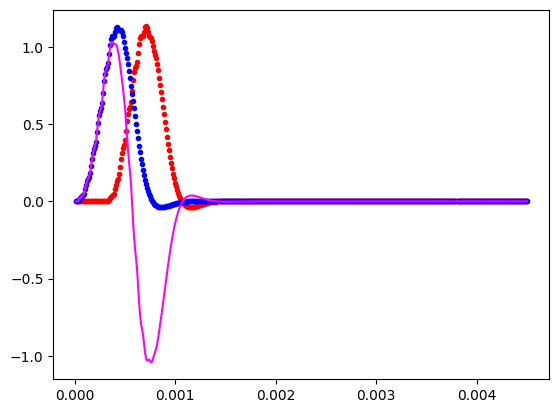

In [19]:
#CAP y CAP DIFERENCIAL

fm = 100000
t = np.arange(1/fm,a.tiempo_registro+1/fm,1/fm)
plt.plot(t,a.electrodos[0].cap,'r .')
plt.plot(t,a.electrodos[1].cap,'b .')
plt.plot(t,a.cap_diferencial(posicion_1=1,posicion_2=0),'magenta')
#plt.plot(t,a.electrodos[0].sfap[0]/max(a.electrodos[0].sfap[0]),'magenta')

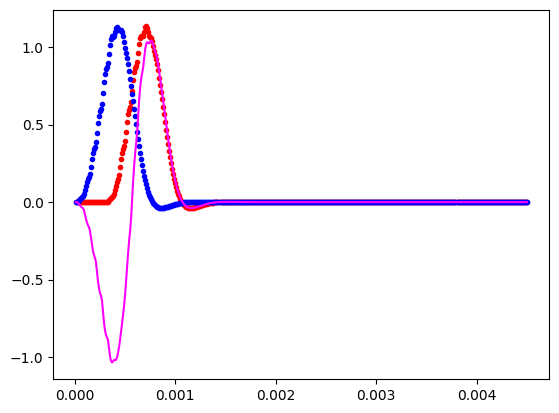

In [27]:
#CAP y CAP DIFERENCIAL

fm = 100000
t = np.arange(1/fm,a.tiempo_registro+1/fm,1/fm)
plt.plot(t,a.electrodos[0].cap,'r .')
plt.plot(t,a.electrodos[1].cap,'b .')
plt.plot(t,a.cap_diferencial(posicion_1=0,posicion_2=1),'magenta')
#plt.plot(t,a.estimulo[0])



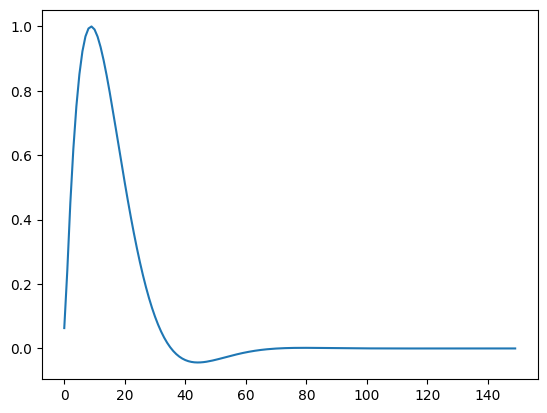

In [33]:
plt.plot(a.estimulo[0])

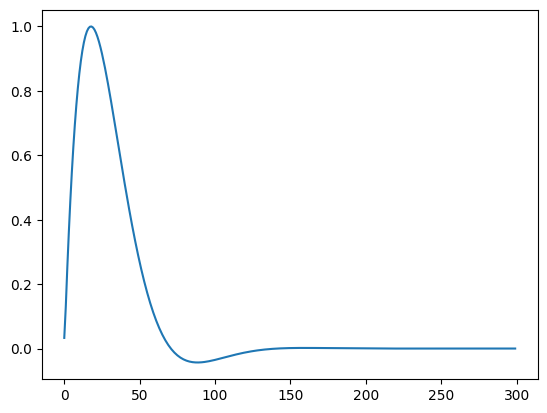

In [50]:
plt.plot(a.estimulo[0])

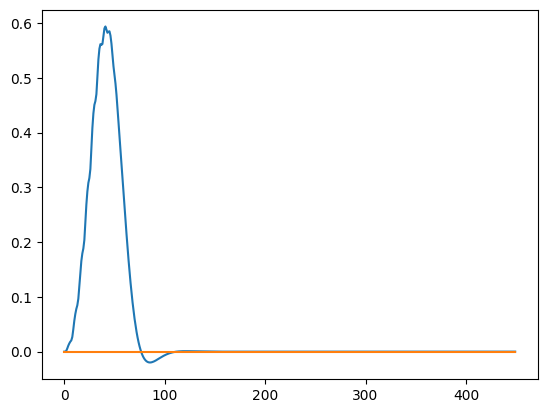

In [9]:
#Plot de cada SFAP del electrodo 0

for i in range(len(a.electrodos[0].sfap)):
    plt.plot(a.electrodos[1].sfap[i])
plt.show()

In [8]:
a.electrodos[0].sfap


array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  2.27314750e-03,
         8.68954941e-03,  1.62085077e-02,  2.22684335e-02,
         2.70190954e-02,  3.06048442e-02,  3.84773978e-02,
         5.51387329e-02,  7.36025117e-02,  8.79937892e-02,
         9.87671607e-02,  1.06355617e-01,  1.19527058e-01,
         1.45540932e-01,  1.73570128e-01,  1.94521194e-01,
         2.09243067e-01,  2.29919231e-01,  2.66663218e-01,
         3.04944062e-01,  3.32574442e-01,  3.50888174e-01,
         3.61136873e-01,  3.78914390e-01,  4.17166543e-0

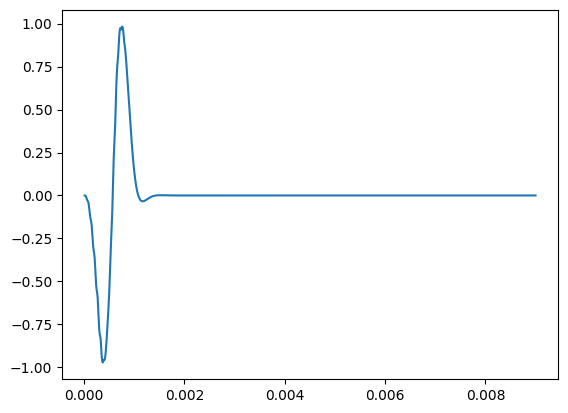

In [42]:
plt.plot(t,a.cap_diferencial(posicion_1=0,posicion_2=1))

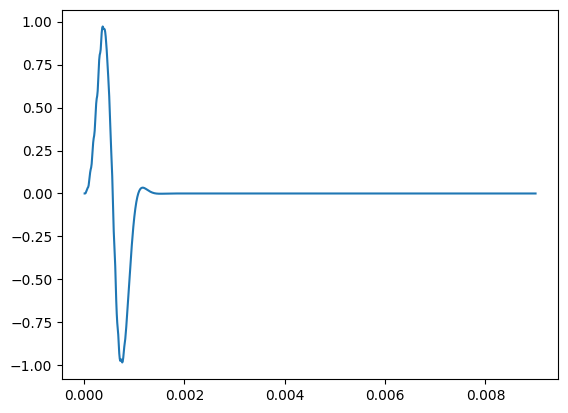

In [43]:
plt.plot(t,a.cap_diferencial(posicion_1=1,posicion_2=0))

### Estimulo sin nombre con varios picos

In [23]:
a = Entorno(nombre='Mi_experimento')
a.crear_nervio(diametro = 500,metodo_poblacion = 'uniforme_con_superposicion',diametro_fibra=4.5,distancia_nodos=2000,longitud=50000,porcentaje_cobertura=100,num_fibras=200,var_diametro=1.5,variacion = 0)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -250,pos_z = 10000,zona_influencia=4000,grosor=0,funcion = funcion_trapecio)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -250,pos_z = 20000,zona_influencia=4000,grosor=0,funcion = funcion_trapecio)
a.crear_estimulo(tipo_estimulo='sin_nombre',frec_muestreo=100000,tiempo_estimulo=0.005,lista_inicio = [0,0.001,0.002],frec_corte = 1000,orden_filtro = 2)
#a.informe_experimento(guardar=True)


In [24]:
a.sfap()
a.cap()

In [8]:
lista = a.nervio.informacion_fibras()[:,2]
for x in lista:
    if x<=0:
        print("ERROR")


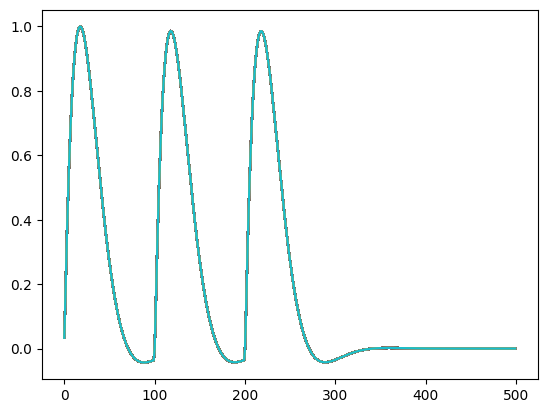

In [25]:
for i in range(len(a.estimulo)):
    plt.plot(a.estimulo[i])

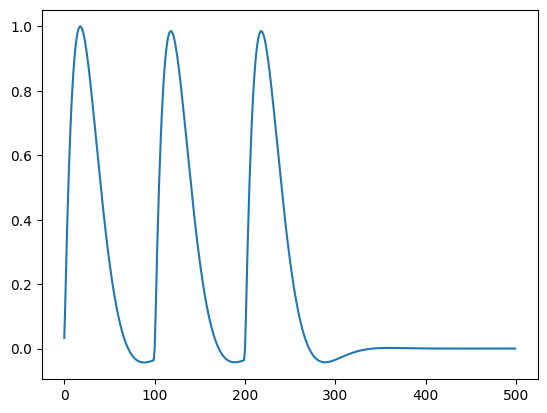

In [22]:
plt.plot(a.estimulo[0])